source: https://debuggercafe.com/visualizing-filters-and-feature-maps-in-convolutional-neural-networks-using-pytorch/

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import cv2 as cv
import argparse
from torchvision import models, transforms

/home/mila/s/sara.ebrahim-elkafrawy/.conda/envs/ffcv2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import sys
import inspect
from pathlib import Path

CURR_DIR = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
PARENT_DIR = os.path.dirname(CURR_DIR)
sys.path.insert(0, "/home/mila/s/sara.ebrahim-elkafrawy/scratch/ecosystem_project/remote_sensing/")

In [3]:
from models.moco2_module import MocoV2
from omegaconf import OmegaConf, DictConfig
from copy import deepcopy

/home/mila/s/sara.ebrahim-elkafrawy/.conda/envs/ffcv2/lib/python3.9/site-packages/pl_bolts/utils/warnings.py:30: UserWarning: You want to use `gym` which is not installed yet, install it with `pip install gym`.
  stdout_func(


In [4]:
exp_config_path = "/home/mila/s/sara.ebrahim-elkafrawy/scratch/ecosystem_project/remote_sensing/configs/geo_ssl.yaml"
trainer_config_path = "/home/mila/s/sara.ebrahim-elkafrawy/scratch/ecosystem_project/remote_sensing/configs/trainer.yaml"

# fetch the requiered arguments
exp_opts = OmegaConf.load(exp_config_path)
trainer_opts = OmegaConf.load(trainer_config_path)

all_opts = OmegaConf.merge(exp_opts, trainer_opts)

In [5]:
# # SeCo resnet50 ssl for 200 epochs
# seco_ckpt_path = "/home/mila/s/sara.ebrahim-elkafrawy/scratch/ecosystem_project/ckpts/seco_resnets/seco_resnet50_1m.ckpt"
# model_ckpt = MocoV2.load_from_checkpoint(seco_ckpt_path, opts=all_opts)
# model = deepcopy(model_ckpt.encoder_q)

In [6]:
# GeoLife resnet50 SSL for 232 epochs
geo_ckpt_path = "/home/mila/s/sara.ebrahim-elkafrawy/scratch/ecosystem_project/ckpts/multigpu_correct_augmentations_epoch_232.ckpt"
model_ckpt = MocoV2.load_from_checkpoint(geo_ckpt_path, opts=all_opts)
model = deepcopy(model_ckpt.encoder_q)

/home/mila/s/sara.ebrahim-elkafrawy/.conda/envs/ffcv2/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/mila/s/sara.ebrahim-elkafrawy/.conda/envs/ffcv2/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [5]:
# pretrained resnet50 with ImageNet load the model
model = models.resnet50(pretrained=True)

model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 49 conv layers in this list

# get all the model children as list
model_children = list(model.children())

/home/mila/s/sara.ebrahim-elkafrawy/.conda/envs/ffcv2/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/mila/s/sara.ebrahim-elkafrawy/.conda/envs/ffcv2/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The following code shows how to retrieve all the convolutional layers and their weights.

In [6]:
# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 49


If you want, then you can also print the saved convolutional layers and the weights using the following code.

In [4]:
# # take a look at the conv layers and the respective weights
# for weight, conv in zip(model_weights, conv_layers):
#     # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
#     print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

# Visualizing Convolutional Layer Filters

In this section, we will visualize the convolutional layer filters. For the sake of simplicity, we will only visualize the filters of the first convolutional layer.

## first conv filters of size (7,7,3)

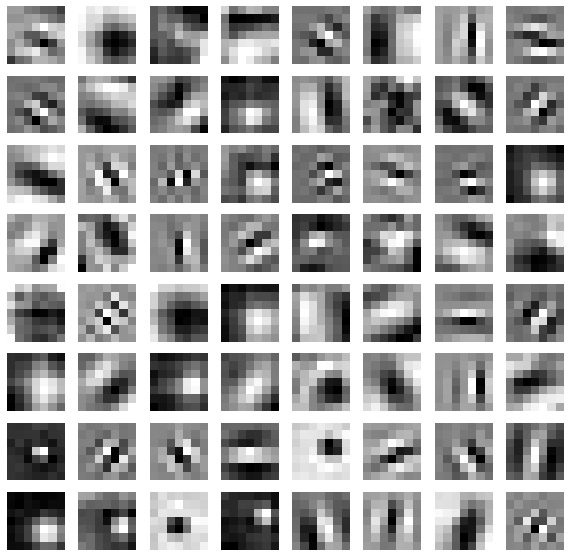

In [20]:
# visualize the first conv layer filters
plt.figure(figsize=(10, 10))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
    plt.rcParams['savefig.facecolor']='white'
    plt.savefig('resnet50_Geo_conv1_filter.png')
plt.show()

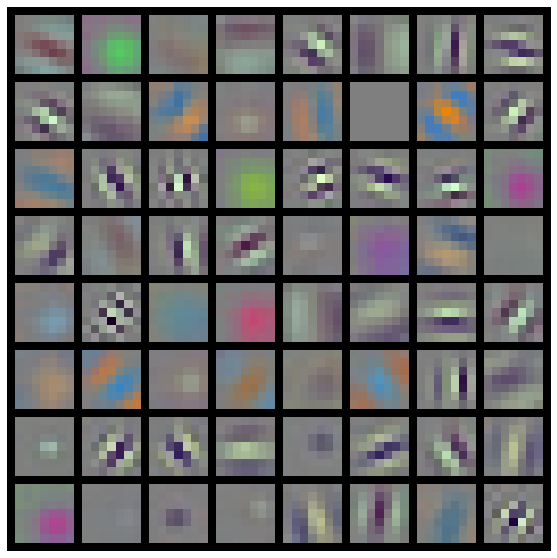

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import utils

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, scale_each=False, padding=padding)
    plt.figure( figsize=(10,10) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))


layer = 1
filter = model_weights[0].data.clone()
visTensor(filter, ch=0, allkernels=False)
plt.rcParams['savefig.facecolor']='black'
plt.savefig('resnet50_conv1_filter_allScaled_color.png')
plt.axis('off')
plt.ioff()
plt.show()

In [10]:
filter_np = filter.numpy().reshape(64,-1)
filter_np.shape

(64, 147)

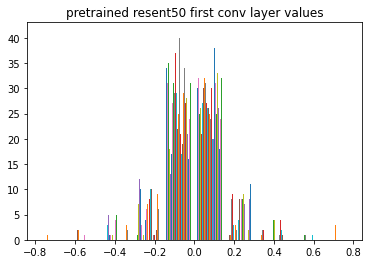

In [14]:
plt.title('pretrained resent50 first conv layer values')
plt.hist(filter_np);
plt.rcParams['savefig.facecolor']='white'
plt.savefig('resnet50_conv1_filter_histogram.png')

## visualize 2nd conv filter

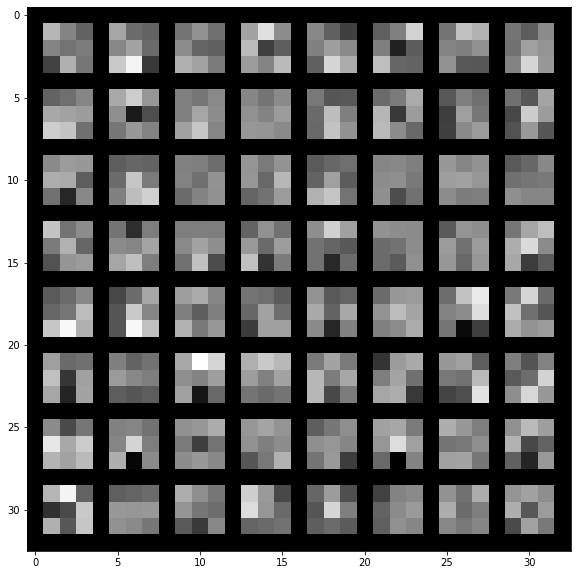

In [28]:
filter = model_weights[8].data.clone()
visTensor(filter, ch=0, allkernels=False)

In [105]:
def get_top_filters(conv_filter_idx, top_k):
    
    num_filters, num_input_ch, w, h = model_weights[conv_filter_idx].shape
    norms = np.zeros((num_input_ch, num_filters))
    final_filters = np.zeros((num_input_ch, top_k, w, h))
    
    for input_filter_idx in range(num_input_ch):
        for new_filter_idx in range(num_filters):
            norms[input_filter_idx, new_filter_idx] = np.linalg.norm(
                            model_weights[conv_filter_idx][new_filter_idx, input_filter_idx, :, :].detach().numpy())
    
#     print(norms.shape)
    sorted_arr_idx = np.argsort(norms)
    top_indices = sorted_arr_idx[:, -top_k:, ]
#     print(top_indices.shape)
    for i, idx in enumerate(top_indices):
        final_filters[i] = model_weights[conv_filter_idx][top_indices[i], i,: ,:].detach().numpy()
        
    return final_filters

In [112]:
final_filters = get_top_filters(conv_filter_idx=1, top_k=3)

In [113]:
final_filters.shape, model_weights[0].shape

((64, 3, 1, 1), torch.Size([64, 3, 7, 7]))

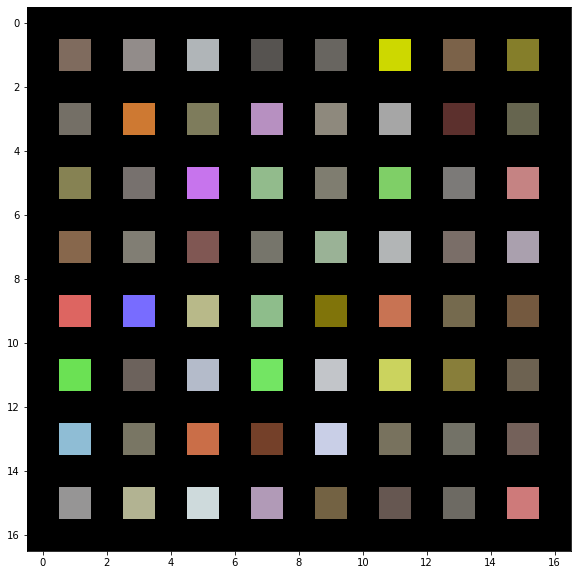

In [114]:
visTensor(torch.from_numpy(final_filters), ch=0, allkernels=False)

# Reading the Image and Defining the Transforms

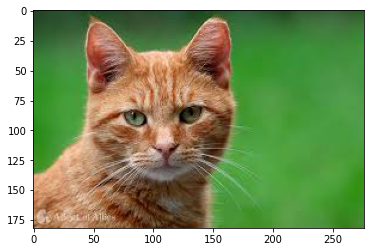

torch.Size([3, 512, 512])
torch.Size([1, 3, 512, 512])


In [13]:
# read and visualize an image
img = cv.imread(f"../images/cat.jpeg")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
# define the transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])
img = np.array(img)
# apply the transforms
img = transform(img)
print(img.size())
# unsqueeze to add a batch dimension
img = img.unsqueeze(0)
print(img.size())

# Visualizing the Feature Maps of the Convolutional Layers

Visualizing the feature maps of the image after passing through the convolutional layers of the ResNet-50 model consists of two steps.

    Passing the image through each convolutional layer and saving each layer’s output.
    Visualizing the feature map blocks of each layer.

Before moving further, I would like to point out that visualizing the feature maps is not really necessary when doing any neural network projects. But if you are carrying out any large scale projects or writing a novel research paper, especially in the computer vision field, then it is very common to analyze the feature maps.

When reading deep learning computer vision research papers, then you may have noticed that many authors provide activation maps for the input image. This is specifically to show which part of the image activates that particular layer’s neurons in a deep neural network model. This gives the authors as well as the reader a good idea of **what the neural network sees**.

# Passing the Input Image Through Each Convolutional Layer

We will first give the image as an input to the first convolutional layer. After that, we will use a for loop to pass the last layer’s outputs to the next layer, until we reach the last convolutional layer.

In [14]:
# pass the image through all the layers
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

# Visualizing the Feature Maps

This is the final step. We will write the code to visualize the feature maps that we just saved.

Notice that the upper layers (near the fully connected layers) have many feature maps, in the range of 512 to 2048. But we will only visualize 64 feature maps from each layer as any more than that will make the outputs really cluttered.

The following code shows how to iterate through each layer’s output and save the feature maps.

torch.Size([64, 256, 256])
Saving layer 0 feature maps...
torch.Size([64, 256, 256])
Saving layer 1 feature maps...
torch.Size([64, 256, 256])
Saving layer 2 feature maps...
torch.Size([256, 256, 256])
Saving layer 3 feature maps...
torch.Size([64, 256, 256])
Saving layer 4 feature maps...
torch.Size([64, 256, 256])
Saving layer 5 feature maps...
torch.Size([256, 256, 256])
Saving layer 6 feature maps...
torch.Size([64, 256, 256])
Saving layer 7 feature maps...
torch.Size([64, 256, 256])
Saving layer 8 feature maps...
torch.Size([256, 256, 256])
Saving layer 9 feature maps...
torch.Size([128, 256, 256])
Saving layer 10 feature maps...
torch.Size([128, 128, 128])
Saving layer 11 feature maps...
torch.Size([512, 128, 128])
Saving layer 12 feature maps...
torch.Size([128, 128, 128])
Saving layer 13 feature maps...
torch.Size([128, 128, 128])


KeyboardInterrupt: 

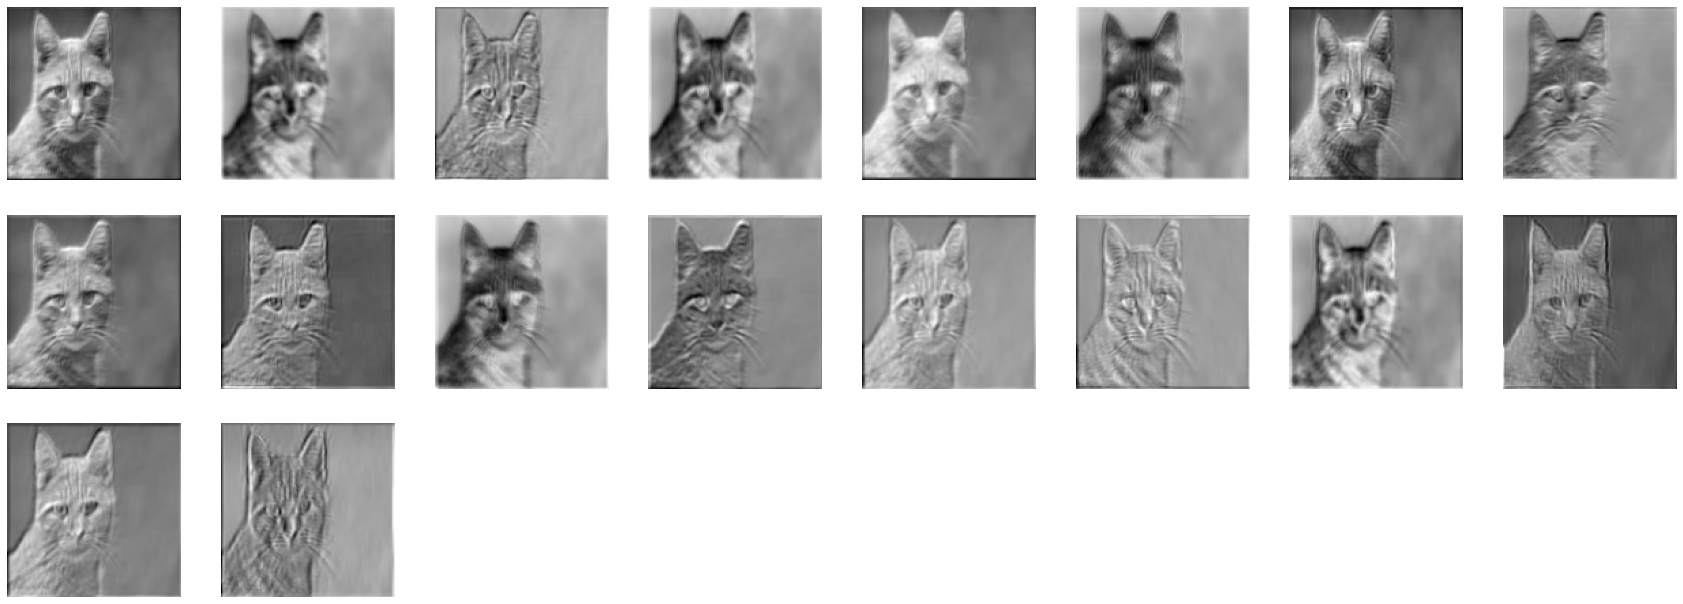

In [15]:
# visualize 64 features from each layer 
# (although there are more feature maps in the upper layers)
for num_layer in range(len(outputs)):
    plt.figure(figsize=(30, 30))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 64: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(8, 8, i + 1)
        plt.imshow(filter, cmap='gray')
        plt.axis("off")
    print(f"Saving layer {num_layer} feature maps...")
    plt.savefig(f"layer_{num_layer}.png")
    # plt.show()
    plt.close()